In [1]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

# Problem 1

In [7]:
data=np.loadtxt('fgas_spt.dat',delimiter=' ')
x=data[:,0]
y=data[:,1]
dy=data[:,2]

In [20]:
def model(theta,x):
    return theta[0]*(1+theta[1]*x)

def log_prior(theta):
    if 0 < theta[0] < 0.5 and -0.5 < theta[1] < 0.5:
        return 0.0
    return -np.inf

def log_likelihood(theta, x,y,dy):
    yM=model(theta,x)    
    return -0.5 * (np.sum(2*np.pi*dy**2)+np.sum(((y - yM)/dy) ** 2))

def log_posterior(theta, x,y,dy):
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,x,y,dy)

In [21]:
labels=['$f_0$','$f_1$']

def main(x,y,yerr):
    
    p1=np.random.uniform(0,0.5,50)
    p2=np.random.uniform(-0.5,0.5,50)
    pos=np.vstack((p1,p2)).T
    
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, y, yerr))
    sampler.run_mcmc(pos, 2000, progress=True)
    
    try:
        tau = sampler.get_autocorr_time()
        flat_samples = sampler.get_chain(discard=200, flat=True)
        
    except:
        flat_samples = sampler.get_chain(discard=200, flat=True)
        print('MCMC did not converge.')
        
    return flat_samples

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1064.45it/s]


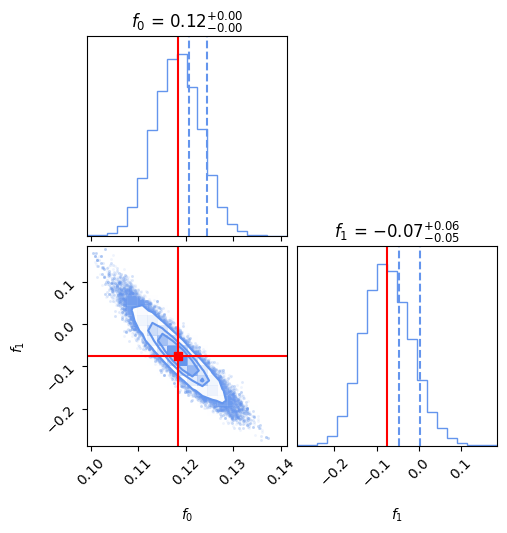

In [24]:
samples = main(x,y,dy)
theta_max=np.median(samples,axis=0)
best_fit_model=model(theta_max,x)
fig = corner.corner(samples,labels=labels,plot_datapoints=True,show_titles=True, 
                    use_math_text=True,truths=theta_max,color='cornflowerblue',truth_color='red',
                    quantiles=[0.68,0.90])

Best fit values are 0.12,-0.07

# Problem 2

In [25]:
!pip install dynesty

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 315.8 kB/s eta 0:00:00 kB/s eta 0:00:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [31]:
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, dy = data

In [43]:
def poly_fit(theta):
    return sum(t * x ** n for (n, t) in enumerate(theta))

def log_likelihood(theta):
    yM=poly_fit(theta)    
    return -0.5 * (np.sum(2*np.pi*dy**2)+np.sum(((y - yM)/dy) ** 2))

def prior_transform(u):
    #Uniform priors -inf to inf
    return np.tan(np.pi * (u - 0.5))

In [44]:
from dynesty import NestedSampler

sampler1 = NestedSampler(log_likelihood, prior_transform, 2, nlive=1500)
sampler2 = NestedSampler(log_likelihood, prior_transform, 3, nlive=1500)

sampler1.run_nested()
res1 = sampler1.results

sampler2.run_nested()
res2 = sampler2.results

10711it [00:05, 1850.57it/s, +1500 | bound: 5 | nc: 1 | ncall: 63936 | eff(%): 19.558 | loglstar:   -inf < -6.291 <    inf | logz: -13.561 +/-  0.065 | dlogz:  0.001 >  1.509]
13380it [00:09, 1456.14it/s, +1500 | bound: 11 | nc: 1 | ncall: 79229 | eff(%): 19.143 | loglstar:   -inf < -5.364 <    inf | logz: -14.616 +/-  0.087 | dlogz:  0.001 >  1.509]


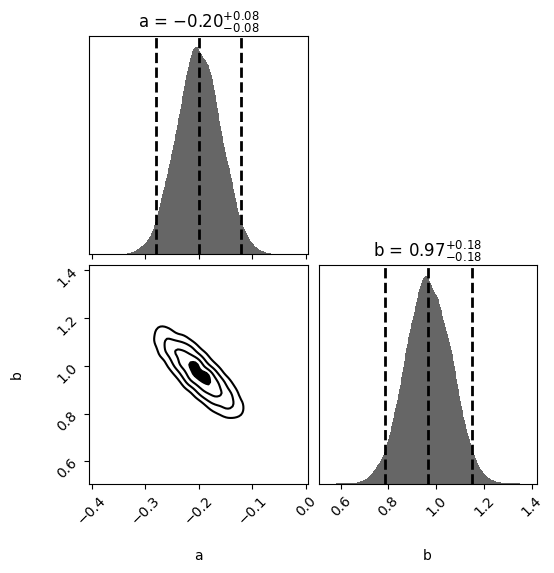

In [45]:
from dynesty import plotting as dyplot

fig, axes = dyplot.cornerplot(res1, show_titles=True, labels=['a','b'],
                              fig=plt.subplots(2, 2, figsize=(6, 6)))

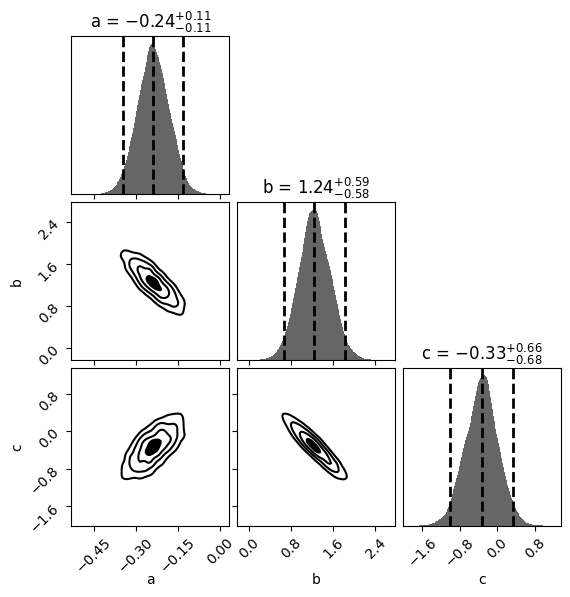

In [46]:
fig, axes = dyplot.cornerplot(res2, show_titles=True, labels=['a','b','c'],
                              fig=plt.subplots(3, 3, figsize=(6, 6)))

In [59]:
sampler1.results

         nlive: 1500
         niter: 10711
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 19.5576270100583
       samples: array([[ 5.14211955e+03, -1.02524736e+00],
       [-3.99753526e+02,  4.02882034e-01],
       [-2.74657800e+02,  3.91247684e+01],
       ...,
       [-2.01278957e-01,  9.71260141e-01],
       [-2.01372780e-01,  9.71768281e-01],
       [-2.01622157e-01,  9.72498248e-01]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([1398,  910, 1216, ..., 1404, 1492,  154])
    samples_it: array([   0,    0,    0, ..., 6313, 9966, 9995])
     samples_u: array([[9.99938098e-01, 2.46032056e-01],
       [7.96263701e-04, 6.21909000e-01],
       [1.15892751e-03, 9.91866007e-01],
       ...,
       [4.36775692e-01, 7.45359550e-01],
       [4.36746990e-01, 7.45442760e-01],
       [4.36670708e-01, 7.45562221e-01]])
         logwt: array([-2.64359043e+10, -1.59808942e+08, -6.78918409e+07, ...,
       -2.07440137e+01, -2.

In [67]:
print('As we can see in the Dynesty output,\
logz are -13.561,-14.616. \nBayes Factor linear to quadratic:', np.exp(-13.561)/np.exp(-14.616))

As we can see in the Dynesty output,logz are -13.561,-14.616. 
Bayes Factor linear to quadratic: 2.8719751539013454


This is in agreement with the value on the blog article, which is 2.3670768618670803

# Problem 3

In [75]:
import pandas as pd
data=pd.read_csv('sdss_quasar2.txt',sep=' ')
data

,SDSS_J,R.A.,Dec.,z,u_mag,sig_u,g_mag,sig_g,r_mag,sig_r,...,sig_z,Radio,X-ray,J_mag,sig_J,H_mag,sig_H,K_mag,sig_K,M_i
0,000009.26+151754.5,0.038605,15.298476,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,...,0.069,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.085
1,000009.38+135618.4,0.039088,13.938447,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,...,0.033,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-27.419
2,000009.42-102751.9,0.039269,-10.464428,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,...,0.047,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.459
3,000011.41+145545.6,0.047547,14.929353,0.4596,19.637,0.030,19.466,0.024,19.362,0.022,...,0.047,-1.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-22.728
4,000011.96+000225.3,0.049842,0.040372,0.4790,18.237,0.028,17.971,0.020,18.025,0.019,...,0.029,0.0,-1.660,16.651,0.136,15.820,0.149,14.821,0.111,-24.046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26270,122827.67-013823.0,187.115322,-1.639748,1.3376,18.823,0.031,18.737,0.016,18.484,0.013,...,0.033,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.035
26271,122828.01-024812.6,187.116733,-2.803524,1.4519,19.144,0.023,19.053,0.018,18.798,0.012,...,0.041,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.014
26272,122828.77+554836.3,187.119897,55.810104,0.8706,19.307,0.032,18.992,0.018,18.827,0.019,...,0.040,0.0,-1.326,0.000,0.000,0.000,0.000,0.000,0.000,-24.608
26273,122829.19+502831.3,187.121663,50.475375,2.0795,19.422,0.038,19.391,0.021,19.235,0.024,...,0.041,0.0,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.397


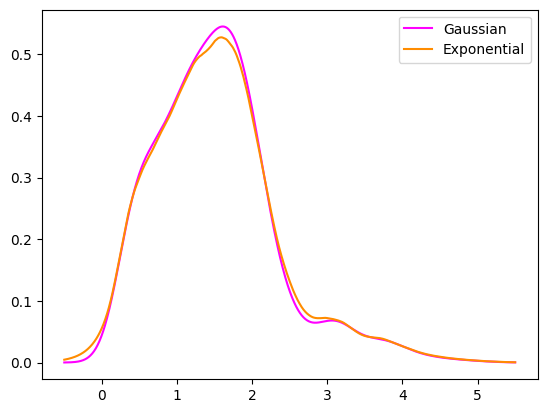

In [82]:
from sklearn.neighbors import KernelDensity
z=data['z'].to_numpy().reshape(-1,1)
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z)
kde2=KernelDensity(kernel='exponential', bandwidth=0.2).fit(z)
x=np.linspace(-0.5,5.5,1000)
plt.plot(x,np.exp(kde1.score_samples(x.reshape(-1,1))),color='fuchsia',label='Gaussian')
plt.plot(x,np.exp(kde2.score_samples(x.reshape(-1,1))),color='darkorange',label='Exponential')
plt.legend()